In [9]:
# Cell 1
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)

def imshow_pair(img1_bgr, img2_bgr, t1="Before", t2="After"):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2RGB)); ax1.set_title(t1); ax1.axis('off')
    ax2.imshow(cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2RGB)); ax2.set_title(t2); ax2.axis('off')
    plt.show()

def apply_clahe_luminance(bgr, clip_limit=2.0, tile_grid=(8,8)):
    """CLAHE on Lab 'L' only (preserve a/b color)."""
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    L, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid)
    Lc = clahe.apply(L)
    out = cv2.cvtColor(cv2.merge([Lc, a, b]), cv2.COLOR_LAB2BGR)
    return out

def adjust_luminance_bc(bgr, contrast_gain=1.0, brightness_shift=0.0, gamma=1.0):
    """
    Luminance-only brightness/contrast (optional gamma).
    contrast_gain >1 increases contrast; brightness_shift in [-50..50] typical.
    gamma <1 brightens mid-tones; >1 darkens mid-tones.
    """
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB).astype(np.float32)
    L, a, b = cv2.split(lab)  # L in [0,255]
    L_lin = np.clip(contrast_gain * L + brightness_shift, 0, 255)
    if gamma is not None and abs(gamma - 1.0) > 1e-6:
        Ln = L_lin / 255.0
        Lg = np.power(np.clip(Ln, 0, 1), gamma) * 255.0
        L_out = Lg
    else:
        L_out = L_lin
    out = cv2.cvtColor(cv2.merge([L_out.astype(np.uint8), a.astype(np.uint8), b.astype(np.uint8)]),
                       cv2.COLOR_LAB2BGR)
    return out

def save_same_quality(input_path, image_bgr, output_path=None, jpeg_quality_fallback=95, png_compression=3):
    """
    Save with same extension as input. For JPEG, use a high-quality fallback (95) since
    exact original quality isn't directly available via OpenCV. For PNG, use moderate compression.
    """
    if output_path is None:
        root, ext = os.path.splitext(input_path)
        output_path = root + "_enhanced" + ext

    ext = os.path.splitext(output_path)[1].lower()
    params = []
    if ext in [".jpg", ".jpeg"]:
        params = [cv2.IMWRITE_JPEG_QUALITY, int(jpeg_quality_fallback)]
    elif ext == ".png":
        params = [cv2.IMWRITE_PNG_COMPRESSION, int(png_compression)]
    # (TIFF/BMP/WebP will use OpenCV defaults)

    ok = cv2.imwrite(output_path, image_bgr, params)
    print(f"Saved: {output_path} (ok={ok})")
    return output_path


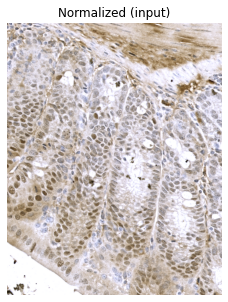

In [10]:
# Cell 2
# Point this to the ALREADY color-normalized image you feed your pipeline.
norm_path = "dataset/Whole_Slides_Segments_Processed/Mouse/patches_nm/patch_0002.png"  # <-- change this
norm_bgr  = cv2.imread(norm_path, cv2.IMREAD_COLOR)
assert norm_bgr is not None, "Failed to read normalized image"
plt.imshow(cv2.cvtColor(norm_bgr, cv2.COLOR_BGR2RGB)); plt.title("Normalized (input)"); plt.axis('off'); plt.show()


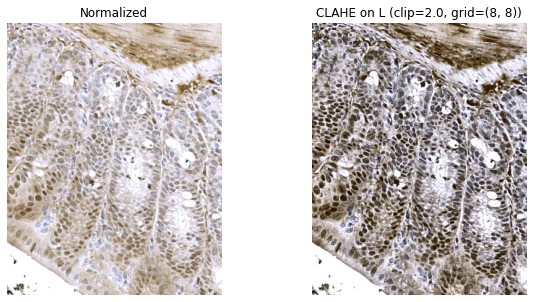

In [11]:
# Cell 3
CLAHE_CLIP_LIMIT = 2.0     # try 1.6–3.0
CLAHE_TILE_GRID  = (8, 8)  # try (8,8) or (12,12)

clahe_bgr = apply_clahe_luminance(norm_bgr, clip_limit=CLAHE_CLIP_LIMIT, tile_grid=CLAHE_TILE_GRID)
imshow_pair(norm_bgr, clahe_bgr,
            t1="Normalized",
            t2=f"CLAHE on L (clip={CLAHE_CLIP_LIMIT}, grid={CLAHE_TILE_GRID})")



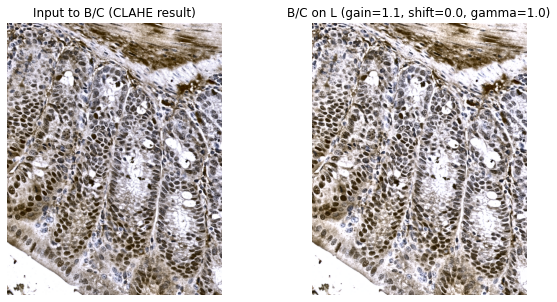

In [12]:
# Cell 4
# Start from CLAHE result (as you requested)
CONTRAST_GAIN     = 1.10   # 1.0 = no change; 1.05–1.25 usually enough
BRIGHTNESS_SHIFT  = 0.0    # in Lab L units; [-30..30] typical
GAMMA             = 1.00   # <1 brightens mids (e.g., 0.9); >1 darkens (e.g., 1.1)

bc_bgr = adjust_luminance_bc(clahe_bgr,
                             contrast_gain=CONTRAST_GAIN,
                             brightness_shift=BRIGHTNESS_SHIFT,
                             gamma=GAMMA)

imshow_pair(clahe_bgr, bc_bgr,
            t1="Input to B/C (CLAHE result)",
            t2=f"B/C on L (gain={CONTRAST_GAIN}, shift={BRIGHTNESS_SHIFT}, gamma={GAMMA})")


In [13]:
# Cell 5
# Save with same extension as the input path; JPEG uses a high-quality fallback (95),
# PNG uses moderate compression so visual quality is unchanged.
out_path = save_same_quality(norm_path, bc_bgr,
                             output_path=None,          # auto: append _enhanced before extension
                             jpeg_quality_fallback=95,  # adjust if you prefer
                             png_compression=3)         # 0=none, 9=max (lossless)


Saved: dataset/Whole_Slides_Segments_Processed/Mouse/patches_nm/patch_0002_enhanced.png (ok=True)


  0%|          | 0/18 [00:00<?, ?it/s]

[INFO] Processing 18 file(s) from:
  dataset/Whole_Slides_Segments_Processed/Mouse/patches_nm
Saving to:
  dataset/Whole_Slides_Segments_Processed/Mouse/patches_nm_pr



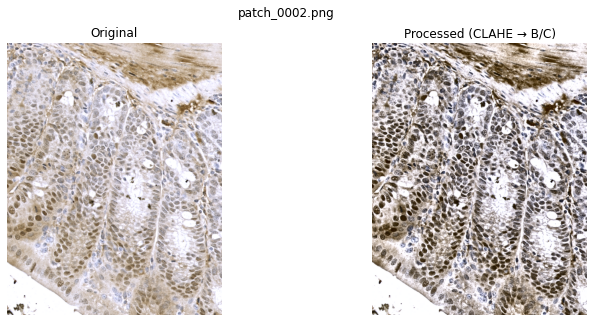

100%|██████████| 18/18 [00:07<00:00,  2.39it/s]


[DONE] Success: 18  |  Failed: 0


In [14]:
# One-cell batch processor: CLAHE (L-only) → Brightness/Contrast (L-only) → save PNGs
# Requires: opencv-python, numpy, matplotlib (for optional preview)

import os, cv2, numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

# =======================
# USER SETTINGS (edit these)
# =======================
IN_DIR   = "dataset/Whole_Slides_Segments_Processed/Mouse/patches_nm"          # <- folder with PNGs
OUT_DIR  = "dataset/Whole_Slides_Segments_Processed/Mouse/patches_nm_pr"    # <- where to save processed PNGs
RECURSIVE = True                         # set False to only process top-level

# CLAHE params
CLAHE_CLIP_LIMIT = 2.0                   # try 1.6–3.0
CLAHE_TILE_GRID  = (8, 8)                # try (8,8) or (12,12)

# Brightness/Contrast/Gamma (on L)
CONTRAST_GAIN     = 1.10                 # 1.0 = none; 1.05–1.25 typical
BRIGHTNESS_SHIFT  = 0.0                  # in [Lab-L] units; (-30..30) typical
GAMMA             = 1.00                 # <1 brightens mids (0.9); >1 darkens (1.1)

# Saving params (PNG is lossless; compression 0=none…9=max)
PNG_COMPRESSION   = 3

# Preview first file (before/after) inline
SHOW_FIRST_BEFORE_AFTER = True

# =======================
# FUNCTIONS
# =======================
def apply_clahe_luminance(bgr, clip_limit=2.0, tile_grid=(8,8)):
    """CLAHE on Lab 'L' only (preserve color)."""
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    L, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid)
    Lc = clahe.apply(L)
    out = cv2.cvtColor(cv2.merge([Lc, a, b]), cv2.COLOR_LAB2BGR)
    return out

def adjust_luminance_bc(bgr, contrast_gain=1.0, brightness_shift=0.0, gamma=1.0):
    """
    Luminance-only brightness/contrast (+ optional gamma).
    contrast_gain >1 increases contrast; brightness_shift in [-50..50] typical.
    gamma <1 brightens mid-tones; >1 darkens mid-tones.
    """
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB).astype(np.float32)
    L, a, b = cv2.split(lab)  # L in [0,255]
    L_lin = np.clip(contrast_gain * L + brightness_shift, 0, 255)
    if gamma is not None and abs(gamma - 1.0) > 1e-6:
        Ln = L_lin / 255.0
        Lg = (np.clip(Ln, 0, 1) ** gamma) * 255.0
        L_out = Lg
    else:
        L_out = L_lin
    out = cv2.cvtColor(cv2.merge([L_out.astype(np.uint8), a.astype(np.uint8), b.astype(np.uint8)]),
                       cv2.COLOR_LAB2BGR)
    return out

def find_pngs(root, recursive=True):
    p = Path(root)
    if recursive:
        return sorted([f for f in p.rglob("*.png")])
    else:
        return sorted([f for f in p.glob("*.png")])

# =======================
# RUN
# =======================
in_paths = find_pngs(IN_DIR, RECURSIVE)
if not in_paths:
    raise SystemExit(f"No PNG files found under: {IN_DIR}")

OUT_DIR = Path(OUT_DIR)
OUT_DIR.mkdir(parents=True, exist_ok=True)

shown_preview = False
count_ok, count_err = 0, 0

print(f"[INFO] Processing {len(in_paths)} file(s) from:\n  {IN_DIR}\nSaving to:\n  {OUT_DIR}\n")

for src in tqdm(in_paths):
    try:
        # read
        bgr = cv2.imread(str(src), cv2.IMREAD_COLOR)
        if bgr is None:
            raise RuntimeError("cv2.imread returned None")

        # CLAHE (L-only)
        bgr_clahe = apply_clahe_luminance(bgr, clip_limit=CLAHE_CLIP_LIMIT, tile_grid=CLAHE_TILE_GRID)

        # Brightness/Contrast/Gamma (L-only) AFTER CLAHE
        bgr_out = adjust_luminance_bc(
            bgr_clahe,
            contrast_gain=CONTRAST_GAIN,
            brightness_shift=BRIGHTNESS_SHIFT,
            gamma=GAMMA
        )

        # mirror relative path
        rel   = src.relative_to(IN_DIR)
        out_f = OUT_DIR / rel
        out_f.parent.mkdir(parents=True, exist_ok=True)

        # save PNG with chosen compression
        ok = cv2.imwrite(str(out_f), bgr_out, [cv2.IMWRITE_PNG_COMPRESSION, int(PNG_COMPRESSION)])
        if not ok:
            raise RuntimeError("cv2.imwrite failed")
        count_ok += 1

        # optional preview for first successfully processed file
        if SHOW_FIRST_BEFORE_AFTER and not shown_preview:
            shown_preview = True
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
            ax1.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)); ax1.set_title("Original"); ax1.axis('off')
            ax2.imshow(cv2.cvtColor(bgr_out, cv2.COLOR_BGR2RGB)); ax2.set_title("Processed (CLAHE → B/C)"); ax2.axis('off')
            plt.suptitle(str(rel))
            plt.show()

    except Exception as e:
        count_err += 1
        print(f"[WARN] Failed: {src} -> {e}")

print(f"\n[DONE] Success: {count_ok}  |  Failed: {count_err}")


mean |Δa|, |Δb| = 0.067, 0.078   (≈0–2 expected)


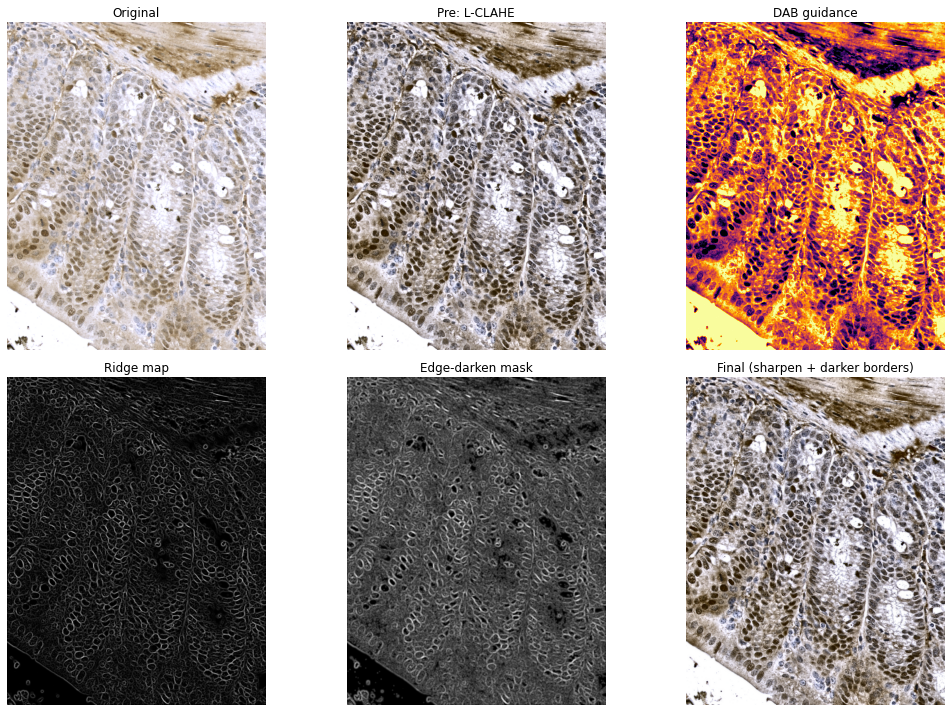

In [21]:
# --- Color-preserving, border-aware sharpening + darker edges for U-shape walls ---

import cv2, numpy as np, matplotlib.pyplot as plt
from skimage import color, exposure, filters
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

# ---------- helpers ----------
def rescale_by_percentile(x, lo=2, hi=98):
    p_lo, p_hi = np.percentile(x, (lo, hi)).astype(float)
    if not np.isfinite(p_lo) or not np.isfinite(p_hi) or p_lo == p_hi:
        return exposure.rescale_intensity(x, in_range='image')
    return exposure.rescale_intensity(x, in_range=(float(p_lo), float(p_hi)))

def lab_split_u8(bgr_u8):
    lab = cv2.cvtColor(bgr_u8, cv2.COLOR_BGR2LAB)
    L, a, b = cv2.split(lab)
    return L, a, b

def lab_merge_u8(L_u8, a_u8, b_u8):
    lab = cv2.merge([L_u8.astype(np.uint8),
                     a_u8.astype(np.uint8),
                     b_u8.astype(np.uint8)])
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

# ---------- settings (tweak) ----------
img_path       = "dataset/Whole_Slides_Segments_Processed/Mouse/patches_2/patch_0002.png"
clahe_clip_pre = 1.8
clahe_grid     = (8, 8)

ridge_sigmas   = (1, 2, 3)
ridge_weight   = 0.7
edge_weight    = 0.3
sharp_amount   = 1.2

bilat_sigmaC   = 14
bilat_sigmaS   = 14
canny_lo, canny_hi = 40, 120

final_clahe    = 0.0

# NEW: edge darkening controls (in Lab L units)
DARKEN_EDGES_GAIN   = 18   # how much to darken edges (try 12–25)
DARKEN_EDGE_DILATE  = 1    # number of 3x3 dilations to slightly widen dark band (0–2)

# ---------- load (uint8 BGR) ----------
bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
assert bgr is not None, "Cannot read image"
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

# ---------- FREEZE CHROMA ONCE ----------
L0, a0, b0 = lab_split_u8(bgr)

# ---------- PRE: gentle L-CLAHE (colors preserved) ----------
clahe = cv2.createCLAHE(clipLimit=clahe_clip_pre, tileGridSize=clahe_grid)
L_pre = clahe.apply(L0)
pre_bgr = lab_merge_u8(L_pre, a0, b0)
pre_rgb = cv2.cvtColor(pre_bgr, cv2.COLOR_BGR2RGB)

# ---------- GUIDANCE (on a copy in float 0..1) ----------
rgbf = pre_rgb.astype(np.float32) / 255.0
hed   = color.rgb2hed(rgbf)
dab   = rescale_by_percentile(-hed[..., 2], 2, 98)    # higher = stronger DAB

# ridge on DAB
try:
    ridge = filters.sato(dab, sigmas=ridge_sigmas, black_ridges=False)
    ridge = exposure.rescale_intensity(ridge, out_range=(0,1)).astype(np.float32)
except Exception:
    ridge = dab.astype(np.float32)

# edges from luminance of pre image
pre_gray = cv2.cvtColor(pre_bgr, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(pre_gray, canny_lo, canny_hi)
edges = cv2.GaussianBlur(edges, (0,0), 1.0) / 255.0

# sharpening mask (soft) in [0,1]
mask = np.clip(ridge_weight * ridge + edge_weight * edges, 0, 1)
mask = cv2.GaussianBlur((mask*255).astype(np.uint8), (0,0), 1.2).astype(np.float32)/255.0

# ---------- L-only unsharp with guidance ----------
base   = cv2.bilateralFilter(L_pre, d=0, sigmaColor=bilat_sigmaC, sigmaSpace=bilat_sigmaS).astype(np.float32)
detail = L_pre.astype(np.float32) - base
L_sharp = np.clip(L_pre.astype(np.float32) + sharp_amount * (detail * (0.5 + 0.5*mask)), 0, 255).astype(np.uint8)

# ---------- NEW: darken edges (on L) using the same guidance mask ----------
# Optionally widen the mask slightly so the dark line is more visible
edge_mask = mask.copy()
if DARKEN_EDGE_DILATE > 0:
    k = np.ones((3,3), np.uint8)
    em = (edge_mask*255).astype(np.uint8)
    for _ in range(DARKEN_EDGE_DILATE):
        em = cv2.dilate(em, k, iterations=1)
    edge_mask = (cv2.GaussianBlur(em, (0,0), 0.8)/255.0).astype(np.float32)

L_dark = np.clip(L_sharp.astype(np.float32) - DARKEN_EDGES_GAIN * edge_mask, 0, 255).astype(np.uint8)

# optional tiny final CLAHE on L
if final_clahe > 0:
    L_final = cv2.createCLAHE(clipLimit=final_clahe, tileGridSize=(8,8)).apply(L_dark)
else:
    L_final = L_dark

# merge FINAL L with ORIGINAL a0,b0 (color preserved)
out_bgr = lab_merge_u8(L_final, a0, b0)
out_rgb = cv2.cvtColor(out_bgr, cv2.COLOR_BGR2RGB)

# ---------- verify chroma preservation ----------
orig_lab  = cv2.cvtColor(bgr,     cv2.COLOR_BGR2LAB)
final_lab = cv2.cvtColor(out_bgr, cv2.COLOR_BGR2LAB)
a_diff = np.mean(np.abs(orig_lab[...,1].astype(np.int16) - final_lab[...,1].astype(np.int16)))
b_diff = np.mean(np.abs(orig_lab[...,2].astype(np.int16) - final_lab[...,2].astype(np.int16)))
print(f"mean |Δa|, |Δb| = {a_diff:.3f}, {b_diff:.3f}   (≈0–2 expected)")

# ---------- show panels ----------
fig, axs = plt.subplots(2, 3)
axs[0,0].imshow(rgb);              axs[0,0].set_title("Original"); axs[0,0].axis('off')
axs[0,1].imshow(pre_rgb);          axs[0,1].set_title("Pre: L-CLAHE"); axs[0,1].axis('off')
axs[0,2].imshow(dab, cmap='inferno'); axs[0,2].set_title("DAB guidance"); axs[0,2].axis('off')
axs[1,0].imshow(ridge, cmap='gray'); axs[1,0].set_title("Ridge map"); axs[1,0].axis('off')
axs[1,1].imshow(edge_mask, cmap='gray');  axs[1,1].set_title("Edge-darken mask"); axs[1,1].axis('off')
axs[1,2].imshow(out_rgb);          axs[1,2].set_title("Final (sharpen + darker borders)"); axs[1,2].axis('off')
plt.tight_layout(); plt.show()


In [22]:
# Batch: Color-preserving border-aware sharpening + darker edges for PNGs (lossless save)

import os
from pathlib import Path
import cv2
import numpy as np
from skimage import color, exposure, filters

# Optional progress bar; if missing, it will still run
try:
    from tqdm import tqdm
    TQDM = True
except Exception:
    TQDM = False

# ----------------- helpers -----------------
def rescale_by_percentile(x, lo=2, hi=98):
    p_lo, p_hi = np.percentile(x, (lo, hi)).astype(float)
    if not np.isfinite(p_lo) or not np.isfinite(p_hi) or p_lo == p_hi:
        return exposure.rescale_intensity(x, in_range='image')
    return exposure.rescale_intensity(x, in_range=(float(p_lo), float(p_hi)))

def lab_split_u8(bgr_u8):
    lab = cv2.cvtColor(bgr_u8, cv2.COLOR_BGR2LAB)
    L, a, b = cv2.split(lab)
    return L, a, b

def lab_merge_u8(L_u8, a_u8, b_u8):
    lab = cv2.merge([L_u8.astype(np.uint8),
                     a_u8.astype(np.uint8),
                     b_u8.astype(np.uint8)])
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

def process_one(bgr,
                clahe_clip_pre=1.8, clahe_grid=(8,8),
                ridge_sigmas=(1,2,3), ridge_weight=0.7, edge_weight=0.3,
                sharp_amount=1.2,
                bilat_sigmaC=14, bilat_sigmaS=14,
                canny_lo=40, canny_hi=120,
                final_clahe=0.0,
                darken_edges_gain=18, darken_edge_dilate=1):
    """
    Returns processed BGR (uint8). All color edits are luminance-only; a,b chroma preserved.
    """
    # Freeze chroma once
    L0, a0, b0 = lab_split_u8(bgr)

    # Pre: gentle L-CLAHE
    clahe = cv2.createCLAHE(clipLimit=clahe_clip_pre, tileGridSize=clahe_grid)
    L_pre = clahe.apply(L0)
    pre_bgr = lab_merge_u8(L_pre, a0, b0)

    # Guidance (work on float copy for skimage)
    pre_rgb = cv2.cvtColor(pre_bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    hed = color.rgb2hed(pre_rgb)
    dab = rescale_by_percentile(-hed[..., 2], 2, 98)  # higher=stronger DAB

    # Ridge on DAB (fallback to dab if sato not present)
    try:
        ridge = filters.sato(dab, sigmas=ridge_sigmas, black_ridges=False)
        ridge = exposure.rescale_intensity(ridge, out_range=(0,1)).astype(np.float32)
    except Exception:
        ridge = dab.astype(np.float32)

    # Edges from L
    pre_gray = cv2.cvtColor(pre_bgr, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(pre_gray, canny_lo, canny_hi)
    edges = cv2.GaussianBlur(edges, (0,0), 1.0) / 255.0

    # Sharpening mask [0,1]
    mask = np.clip(ridge_weight * ridge + edge_weight * edges, 0, 1)
    mask = cv2.GaussianBlur((mask*255).astype(np.uint8), (0,0), 1.2).astype(np.float32)/255.0

    # L-only unsharp with guidance
    base   = cv2.bilateralFilter(L_pre, d=0, sigmaColor=bilat_sigmaC, sigmaSpace=bilat_sigmaS).astype(np.float32)
    detail = L_pre.astype(np.float32) - base
    L_sharp = np.clip(L_pre.astype(np.float32) + sharp_amount * (detail * (0.5 + 0.5*mask)), 0, 255).astype(np.uint8)

    # Darken edges on L using the same mask
    edge_mask = mask.copy()
    if darken_edge_dilate > 0:
        k = np.ones((3,3), np.uint8)
        em = (edge_mask*255).astype(np.uint8)
        for _ in range(int(darken_edge_dilate)):
            em = cv2.dilate(em, k, iterations=1)
        edge_mask = (cv2.GaussianBlur(em, (0,0), 0.8)/255.0).astype(np.float32)
    L_dark = np.clip(L_sharp.astype(np.float32) - darken_edges_gain * edge_mask, 0, 255).astype(np.uint8)

    # Optional tiny final L-CLAHE
    if final_clahe > 0:
        L_final = cv2.createCLAHE(clipLimit=final_clahe, tileGridSize=(8,8)).apply(L_dark)
    else:
        L_final = L_dark

    # Merge with original chroma (color preserved)
    out_bgr = lab_merge_u8(L_final, a0, b0)
    return out_bgr

def process_tree(in_dir, out_dir,
                 recursive=True,
                 png_compression=3,
                 **proc_kwargs):
    """
    Process all .png images under in_dir, mirror structure into out_dir, save PNG (lossless).
    png_compression: 0..9 (lossless; affects size/speed only).
    """
    in_dir  = Path(in_dir)
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    files = list(in_dir.rglob("*.png") if recursive else in_dir.glob("*.png"))
    iterator = tqdm(files, desc="Processing") if TQDM else files

    ok, fail = 0, 0
    for src in iterator:
        try:
            bgr = cv2.imread(str(src), cv2.IMREAD_COLOR)
            if bgr is None:
                raise RuntimeError("cv2.imread returned None")

            out_bgr = process_one(bgr, **proc_kwargs)

            rel = src.relative_to(in_dir)
            dst = out_dir / rel
            dst.parent.mkdir(parents=True, exist_ok=True)

            # PNG is lossless; compression does not degrade quality
            params = [cv2.IMWRITE_PNG_COMPRESSION, int(png_compression)]
            if not cv2.imwrite(str(dst), out_bgr, params):
                raise RuntimeError("cv2.imwrite failed")
            ok += 1
        except Exception as e:
            fail += 1
            print(f"[WARN] Failed: {src} -> {e}")

    print(f"\n[DONE] Saved: {ok}   Failed: {fail}   Output root: {out_dir}")

# ----------------- RUN (edit these) -----------------
IN_DIR  = "dataset/Whole_Slides_Segments_Processed/Mouse/patches_2"          # <- change
OUT_DIR = "dataset/Whole_Slides_Segments_Processed/Mouse/patches_2_pr"    # <- change

process_tree(
    IN_DIR,
    OUT_DIR,
    recursive=True,
    png_compression=3,   # 0..9; lossless
    # You can tweak processing knobs below as needed:
    clahe_clip_pre=1.8, clahe_grid=(8,8),
    ridge_sigmas=(1,2,3), ridge_weight=0.7, edge_weight=0.3,
    sharp_amount=1.2,
    bilat_sigmaC=14, bilat_sigmaS=14,
    canny_lo=40, canny_hi=120,
    final_clahe=0.0,
    darken_edges_gain=18, darken_edge_dilate=1
)


Processing: 100%|██████████| 18/18 [00:39<00:00,  2.20s/it]


[DONE] Saved: 18   Failed: 0   Output root: dataset/Whole_Slides_Segments_Processed/Mouse/patches_2_pr


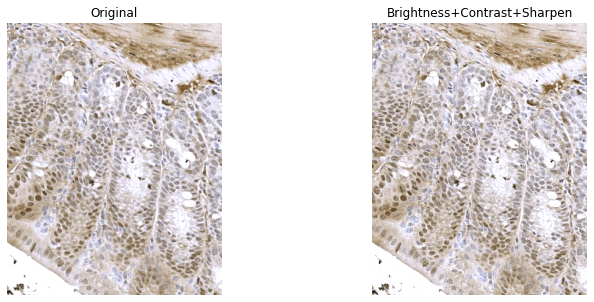

In [25]:
# One-shot: brighten + increase contrast + sharpen edges (color preserved)

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,5)

# ======= settings (edit) =======
img_path = "dataset/Whole_Slides_Segments_Processed/Mouse/patches_nm/patch_0002.png"  # <-- your image
# Brightness/contrast on L (Lab): 
CONTRAST_GAIN    = 1   # 1.0 = none; try 1.05–1.25
BRIGHTNESS_SHIFT = 2.0    # in Lab-L units; ~[-30..30]
GAMMA            = 1.00   # <1 brightens mids; >1 darkens mids (e.g., 0.95 or 1.05)

# Sharpening (unsharp on L):
SHARP_AMOUNT = 1.2        # 1.0–1.6 typical
BLUR_SIGMA   = 1.2        # Gaussian blur std for unsharp (1.0–1.8)
SAVE_OUTPUT  = False      # set True to save
out_path     = "enhanced.png"

# ======= helpers =======
def to_rgb(bgr): return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

def luminance_bc(bgr, contrast_gain=1.0, brightness_shift=0.0, gamma=1.0):
    """Brightness/contrast (and optional gamma) on Lab L channel only."""
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB).astype(np.float32)
    L, a, b = cv2.split(lab)  # L in [0,255]
    # linear B/C
    L_lin = np.clip(contrast_gain * L + brightness_shift, 0, 255)
    # optional gamma in [0,1] domain
    if abs(gamma - 1.0) > 1e-6:
        Ln = np.clip(L_lin/255.0, 0, 1)
        Lg = (Ln ** gamma) * 255.0
        L_out = Lg
    else:
        L_out = L_lin
    out = cv2.cvtColor(cv2.merge([L_out.astype(np.uint8),
                                  a.astype(np.uint8),
                                  b.astype(np.uint8)]), cv2.COLOR_LAB2BGR)
    return out

def unsharp_l_only(bgr, amount=1.2, sigma=1.2):
    """Unsharp masking on Lab L only (edge sharpening, color preserved)."""
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB).astype(np.float32)
    L, a, b = cv2.split(lab)
    # Gaussian blur as base
    L_blur = cv2.GaussianBlur(L, ksize=(0,0), sigmaX=sigma, sigmaY=sigma)
    detail = L - L_blur
    L_sharp = np.clip(L + amount * detail, 0, 255).astype(np.uint8)
    out = cv2.cvtColor(cv2.merge([L_sharp, a.astype(np.uint8), b.astype(np.uint8)]), cv2.COLOR_LAB2BGR)
    return out

# ======= load =======
bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
assert bgr is not None, f"Could not read: {img_path}"

# ======= process =======
# 1) brightness/contrast (L only)
bgr_bc = luminance_bc(bgr, CONTRAST_GAIN, BRIGHTNESS_SHIFT, GAMMA)

# 2) sharpen edges (L only)
bgr_out = unsharp_l_only(bgr_bc, amount=SHARP_AMOUNT, sigma=BLUR_SIGMA)

# ======= show =======
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(to_rgb(bgr));     ax1.set_title("Original"); ax1.axis('off')
ax2.imshow(to_rgb(bgr_out)); ax2.set_title("Brightness+Contrast+Sharpen"); ax2.axis('off')
plt.show()

# ======= optional save (PNG is lossless) =======
if SAVE_OUTPUT:
    ok = cv2.imwrite(out_path, bgr_out, [cv2.IMWRITE_PNG_COMPRESSION, 3])
    print(f"Saved to {out_path}, ok={ok}")
